In [34]:
import theano
import numpy as np
import matplotlib.pylab as plt
import csv, os, random, sys
%matplotlib inline

import lasagne
from lasagne.layers.normalization import BatchNormLayer
from lasagne.layers import Conv2DLayer, InputLayer, ConcatLayer
from lasagne.layers import DenseLayer, Pool2DLayer, FlattenLayer

print "theano",theano.version.full_version
print "lasagne",lasagne.__version__

theano 0.9.0dev4.dev-255aca76a09593f9806a02e53bea002a973f533e
lasagne 0.2.dev1


In [2]:
#Set seed for random numbers:
np.random.seed(1234)
lasagne.random.set_rng(np.random.RandomState(1234))

In [3]:
if sys.version_info[0] == 2:
    from urllib import urlretrieve
else:
    from urllib.request import urlretrieve

def download(filename, source='http://yann.lecun.com/exdb/mnist/'):
    print("Downloading %s" % filename)
    urlretrieve(source + filename, filename)

import gzip
def load_mnist_images(filename):
    if not os.path.exists(filename):
        download(filename)
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=16)
    data = data.reshape(-1, 1, 28, 28).transpose(0,1,3,2)
    data = np.asarray([np.rot90(np.fliplr(x[0])) for x in data])
    data = data.reshape(-1, 1, 28, 28)
    return data / np.float32(255)

def load_mnist_labels(filename):
    if not os.path.exists(filename):
        download(filename)
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=8)
    return data

x_train = load_mnist_images('train-images-idx3-ubyte.gz')
t_train = load_mnist_labels('train-labels-idx1-ubyte.gz')
x_test = load_mnist_images('t10k-images-idx3-ubyte.gz')
t_test = load_mnist_labels('t10k-labels-idx1-ubyte.gz')
x_train, x_val = x_train[:-10000], x_train[-10000:]
t_train, t_val = t_train[:-10000], t_train[-10000:]

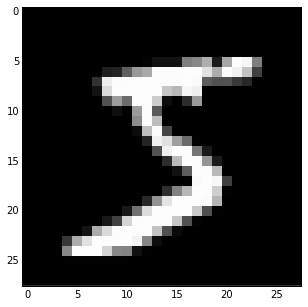

In [4]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 5)
plt.imshow(x_train[0][0],interpolation='none', cmap='gray');

In [5]:
import theano
import theano.tensor as T
import lasagne
import lasagne.layers
from lasagne.layers.normalization import BatchNormLayer
from lasagne.layers import InputLayer, Conv2DLayer, Pool2DLayer, DenseLayer, MaxPool2DLayer
from lasagne.layers import ConcatLayer, DropoutLayer, ReshapeLayer, TransposedConv2DLayer

In [6]:
input_data = T.tensor4('cifar10')
input_var_ex = T.ivector('input_var_ex')

inshape = (None, 1, 28,28)
numhidden = 2

def ConvFactory(data, num_filter, filter_size, stride=1, pad=(0, 0), nonlinearity=lasagne.nonlinearities.rectify):
    data = lasagne.layers.batch_norm(Conv2DLayer(
        data, num_filters=num_filter,
        filter_size=filter_size,
        stride=stride, pad=pad,
        nonlinearity=nonlinearity,
        W=lasagne.init.GlorotUniform(gain='relu')))
    return data

def DeConvFactory(data, num_filter, filter_size, stride=1, pad=(0, 0), nonlinearity=lasagne.nonlinearities.rectify):
    data = lasagne.layers.batch_norm(TransposedConv2DLayer(
        data, num_filters=num_filter,
        filter_size=filter_size, stride=stride, crop=pad,
        nonlinearity=nonlinearity,
        W=lasagne.init.GlorotUniform(gain='relu')))
    return data

net = InputLayer(shape=inshape, input_var=input_data[input_var_ex])
print net.output_shape
l_in = net

net = ConvFactory(data=net, filter_size=3, pad='valid', num_filter=30) 
print net.output_shape

net = ConvFactory(data=net, filter_size=5, pad='valid', num_filter=20) 
print net.output_shape

net = ConvFactory(data=net, filter_size=10, pad='valid', num_filter=10) 
print net.output_shape

net_before_hidden = net

##########

net = FlattenLayer(net)  
net = lasagne.layers.DenseLayer(net, num_units=numhidden,
                                     W=lasagne.init.GlorotUniform(),
                                     nonlinearity=None)
l_hidden = net

print net.output_shape

net = lasagne.layers.DenseLayer(net, num_units=10*13*13,
                                     W=lasagne.init.GlorotUniform(),
                                     nonlinearity=None)

net = ReshapeLayer(net, ([0],10, 13, 13))
print net.output_shape

##########

net = DeConvFactory(data=net, filter_size=10, pad='valid', num_filter=20) 
print net.output_shape

net = DeConvFactory(data=net, filter_size=5, pad='valid', num_filter=30) 
print net.output_shape

net = DeConvFactory(data=net, filter_size=3, pad='valid', num_filter=1, nonlinearity=None)
print net.output_shape
    
l_out = net

(None, 1, 28, 28)
(None, 30, 26, 26)
(None, 20, 22, 22)
(None, 10, 13, 13)
(None, 2)
(None, 10, 13, 13)
(None, 20, 22, 22)
(None, 30, 26, 26)
(None, 1, 28, 28)


In [7]:
target_var = T.matrix('targets')

prediction = lasagne.layers.get_output(l_out)
prediction = prediction.clip(0,1)
hidden = lasagne.layers.get_output(l_hidden)

#define how to make prediction
ae_reconstruct = theano.function(
    inputs=[input_var_ex],
    outputs=prediction,
    givens={input_data: x_train}
)

#define how to output embedding
ae_embed = theano.function(
    inputs=[input_var_ex],
    outputs=lasagne.layers.get_output(l_hidden),
    givens={input_data: x_train}
)

ae_reconstruct_test = theano.function(
    inputs=[input_var_ex],
    outputs=prediction,
    givens={input_data: x_test}
)

In [8]:
batch_size = 100
ae_embedding = np.array([])
for i in range(0,len(x_train),batch_size):
    ae_embedding = np.append(ae_embedding, ae_embed(range(i,i+batch_size)))

ae_embedding = ae_embedding.reshape((len(x_train), numhidden))

/Tmp/lisa/os_v5/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


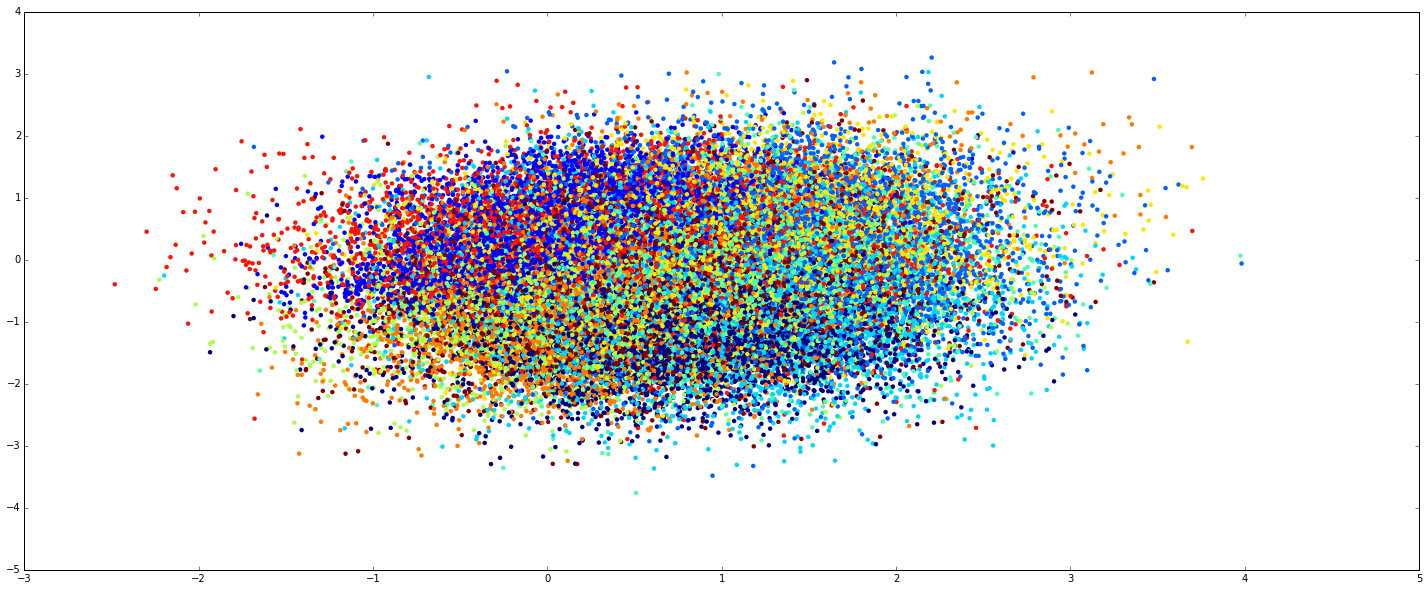

In [9]:
plt.rcParams['figure.figsize'] = (25, 10)
plt.scatter(ae_embedding[:, 0], ae_embedding[:, 1], lw=0,c=t_train);

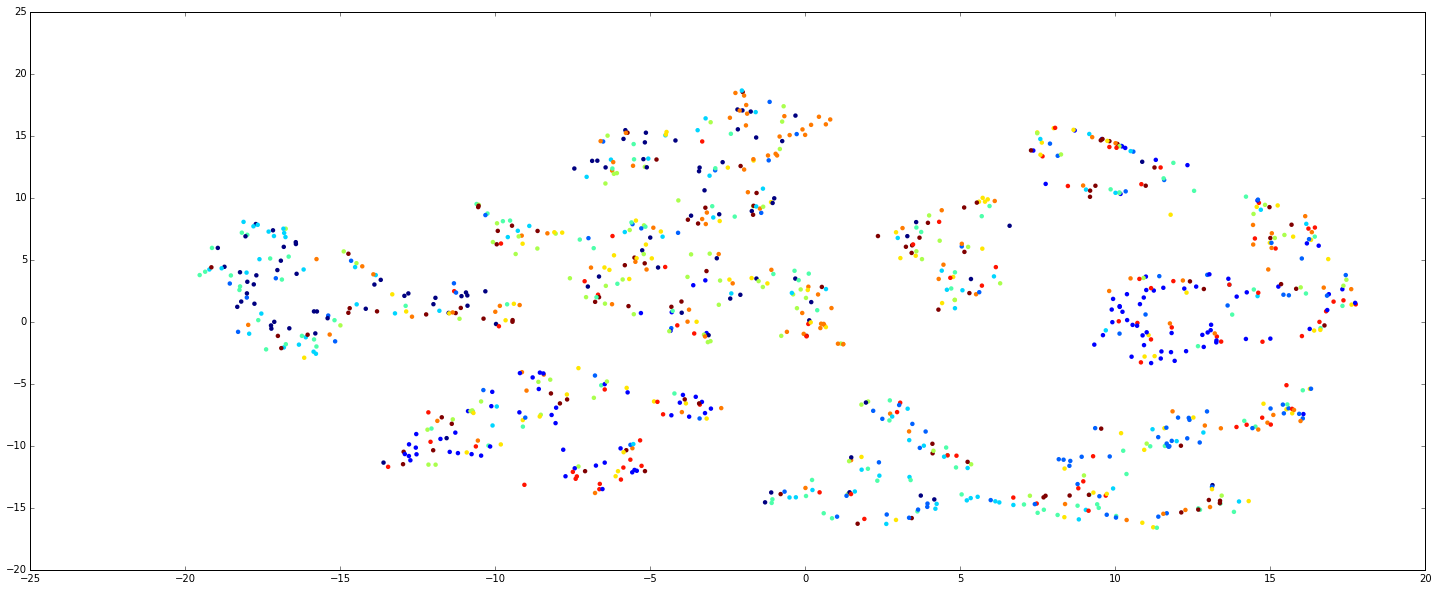

In [10]:
import sklearn.manifold
coor_tsne = sklearn.manifold.TSNE(n_components=2).fit_transform(ae_embedding[:1000])
plt.rcParams['figure.figsize'] = (25, 10)
plt.scatter(coor_tsne[:, 0], coor_tsne[:, 1], lw=0, c=t_train[:1000]);

In [11]:
# create train functions 
lr = theano.shared(np.array(0., dtype=theano.config.floatX))

params_ae = lasagne.layers.get_all_params(l_out, trainable=True)

target_var = T.ivector('target')
rloss = lasagne.objectives.squared_error(prediction,input_data[input_var_ex]).mean()

updates_ae = lasagne.updates.adam(rloss, params_ae, learning_rate=lr)
f_train_ae = theano.function([input_var_ex], 
                          [rloss],
                          updates=updates_ae,
                          givens={input_data: x_train},
                          allow_input_downcast=True)

In [12]:
f_train_ae([0,1])

[array(0.1881476491689682, dtype=float32)]

In [13]:
lr.set_value(0.001)
batch_size = 200
print "batch_size",batch_size

best_valid_error = 9999999.

for j in range(50):
    
    batch_err = []  
    
    # shuffle batches
    todo = range(len(x_train))
    random.shuffle(todo)
    
    for i in range(0,len(x_train),batch_size):
        examples = todo[i:i+batch_size]
        err = f_train_ae(examples)
        batch_err.append(err)
        
    err_result = np.asarray(batch_err).mean(axis=0)
    
    
    ### Test error
    ae_reconstruction = np.array([])
    for i in range(0,len(x_test),batch_size):
        ae_reconstruction = np.append(ae_reconstruction, ae_reconstruct_test(range(i,i+batch_size)))

    ae_reconstruction = ae_reconstruction.reshape((len(x_test), 1, 28, 28))
    valid_error = ((ae_reconstruction - x_test)**2).mean()
    
    best_valid_error = min(best_valid_error,valid_error)
    
    if j % 1 == 0:    
        print j, err_result, valid_error, best_valid_error


batch_size 200
0 [ 0.06971195] 0.0585798979732 0.0585798979732
1 [ 0.05544239] 0.0534347848394 0.0534347848394
2 [ 0.05199392] 0.050891366104 0.050891366104
3 [ 0.04982286] 0.0491770529016 0.0491770529016
4 [ 0.04788835] 0.0476375673638 0.0476375673638
5 [ 0.04649963] 0.0459839832315 0.0459839832315
6 [ 0.04529782] 0.0449693981962 0.0449693981962
7 [ 0.04445618] 0.0443807824304 0.0443807824304
8 [ 0.04380147] 0.0439688832919 0.0439688832919
9 [ 0.04338644] 0.0435332452424 0.0435332452424
10 [ 0.04309788] 0.0432325081253 0.0432325081253
11 [ 0.04278561] 0.043626901422 0.0432325081253
12 [ 0.04256362] 0.0427522624775 0.0427522624775
13 [ 0.04226983] 0.0427996911918 0.0427522624775
14 [ 0.04207701] 0.0424267942455 0.0424267942455
15 [ 0.04191935] 0.0425117623329 0.0424267942455
16 [ 0.04172199] 0.042094490528 0.042094490528
17 [ 0.04168761] 0.0422677805624 0.042094490528
18 [ 0.04147225] 0.0420691366471 0.0420691366471
19 [ 0.04133281] 0.0417137149421 0.0417137149421
20 [ 0.04113171] 0.04

In [14]:
batch_size = 200
ae_embedding = np.array([])
for i in range(0,len(x_train),batch_size):
    ae_embedding = np.append(ae_embedding, ae_embed(range(i,i+batch_size)))

ae_embedding = ae_embedding.reshape((len(x_train), numhidden))

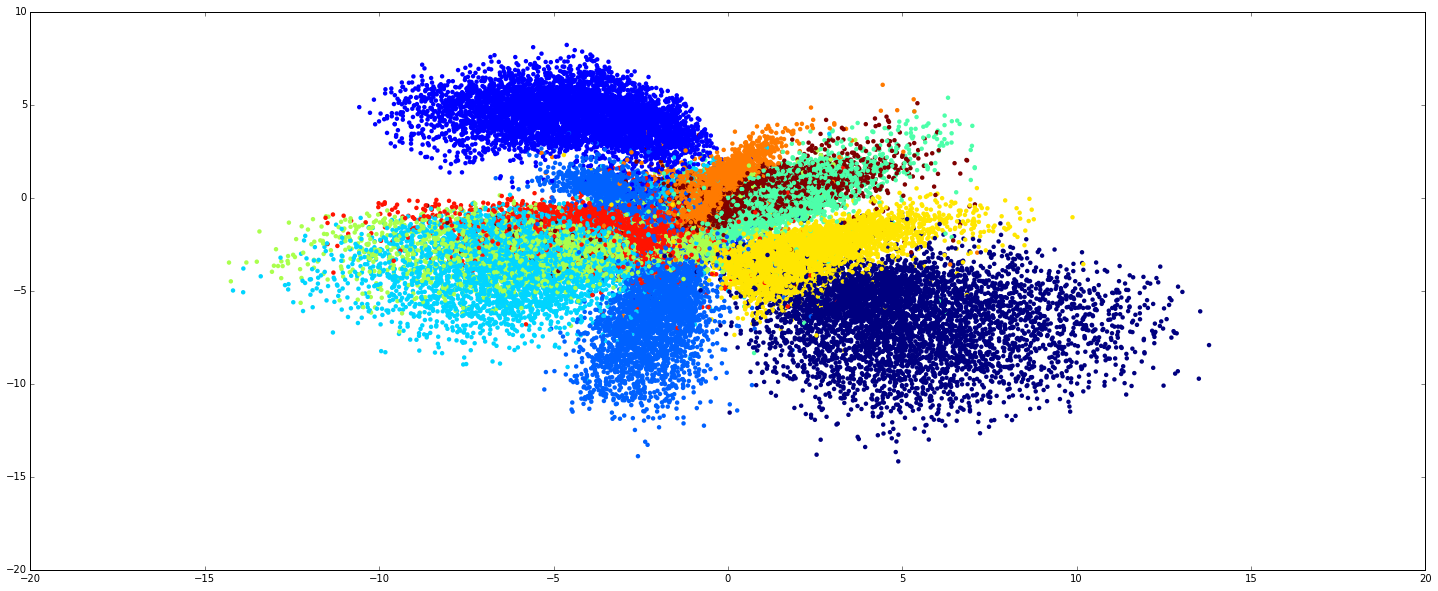

In [15]:
plt.rcParams['figure.figsize'] = (25, 10)
plt.scatter(ae_embedding[:, 0], ae_embedding[:, 1], lw=0,c=t_train);

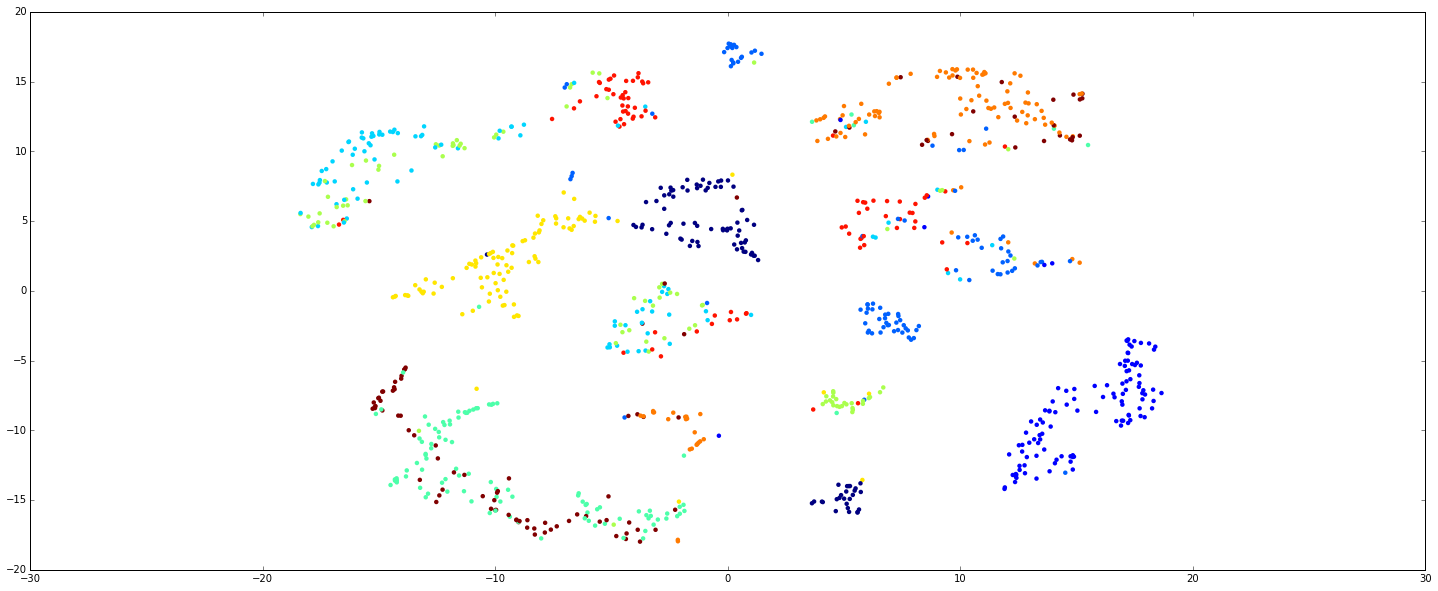

In [16]:
import sklearn.manifold
coor_tsne = sklearn.manifold.TSNE(n_components=2).fit_transform(ae_embedding[:1000])
plt.rcParams['figure.figsize'] = (25, 10)
plt.scatter(coor_tsne[:, 0], coor_tsne[:, 1], lw=0, c=t_train[:1000]);

In [29]:
ae_reconstruction = ae_reconstruct(range(0,batch_size))

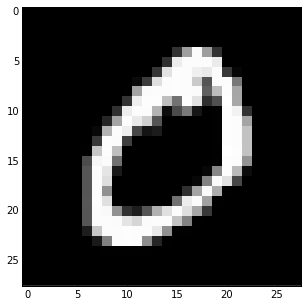

In [32]:
plt.rcParams['figure.figsize'] = (25, 5)
plt.imshow(x_train[1][0],interpolation='none', cmap='gray');

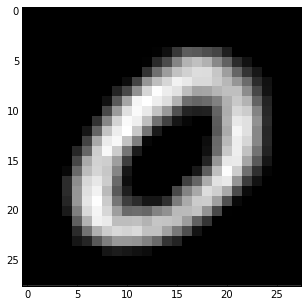

In [33]:
plt.rcParams['figure.figsize'] = (25, 5)
plt.imshow(ae_reconstruction[1][0],interpolation='none', cmap='gray');

In [20]:
ae_reconstruction = ae_reconstruct_test(range(0,batch_size))

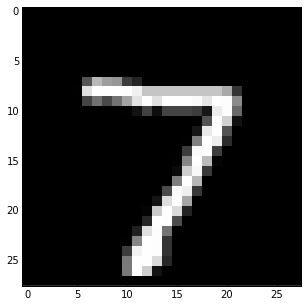

In [21]:
plt.rcParams['figure.figsize'] = (25, 5)
plt.imshow(x_test[0][0],interpolation='none', cmap='gray');

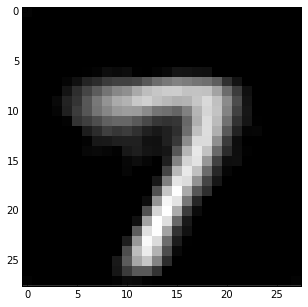

In [22]:
plt.rcParams['figure.figsize'] = (25, 5)
plt.imshow(ae_reconstruction[0][0],interpolation='none', cmap='gray');